In [1]:
import logging
logger = logging.getLogger(__name__)
for system in ['h5py._conv', 'matplotlib', 'PIL']:
     logging.getLogger(system).setLevel(logging.WARNING)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
from dedalus import public as de

In [2]:
nz = 128
IC = 'LBVP' # 'LBVP' -> compute LBVP, 'linear' (or else) -> use linear ICs
verbose = True
q_surface = 1 #0.5

In [3]:
Lx = Ly = 10
Lz = 1
Rayleigh = 1e4 #1e4
Prandtl = 1
Prandtlm = 1

α = 3
β = 1.2 #1.201
γ = 0.25 #0.19
tau_Vallis = 5e-5
ΔT = -1

The non-dimensional tau timescale, relative to the thermal time, is:
\begin{equation}
    \tau = \tau_d \frac{\kappa}{H^2} = 5\times10^{-5}
\end{equation}
with $\tau_d$ the dimensional condensation time (Vallis et al 2019).

In buoyancy timescales,
\begin{align}
    \tau &= \tau_d \sqrt{\alpha \Delta T g} \\
    &= \tau_d \sqrt{\frac{\alpha \Delta T g H^4}{\kappa^2}} \frac{\kappa}{H^2} \\
    & = \sqrt{Ra Pr} \left(\tau_d \frac{\kappa}{H^2}\right) \\
    & = \sqrt{Ra Pr} \times \left(5\times10^{-5}\right) 
\end{align}
or, given $Ra \approx 10^{6}$
\begin{equation}
    \tau \approx 5 \times 10^{-3}
\end{equation}
This indicates that, in buoyancy time units, condensation is rapid compared to buoyant times.  Maybe too rapid.

Meanwhile, the quantity $P \tau$ is:
\begin{align}
    P \tau &= \frac{\sqrt{Ra Pr}}{\sqrt{Ra Pr}} \times \left(5\times10^{-5}\right) \\
    & = 5\times10^{-5}
\end{align}
Things probably don't get better if we multiply all terms through by P$\ldots$

In [4]:
P = (Rayleigh * Prandtl)**(-1/2)         #  diffusion on buoyancy
S = (Rayleigh * Prandtlm)**(-1/2)        #  diffusion on moisture
tau = 3/8 #1e-2 #3/8 #tau_Vallis*(Rayleigh*Prandtl)**(1/2)     #  condensation timescale
print('tau = {:.2g}'.format(tau))

tau = 0.38


In [5]:
# Create bases and domain
coords = de.CartesianCoordinates('x', 'y', 'z')
dist = de.Distributor(coords, dtype=np.float64)
dealias = 2
zb = de.ChebyshevT(coords.coords[2], size=nz, bounds=(0, Lz), dealias=dealias)
z = zb.local_grid(1)

b = dist.Field(name='b', bases=zb)
q = dist.Field(name='q', bases=zb)

τb1 = dist.Field(name='τb1')
τb2 = dist.Field(name='τb2')
τq1 = dist.Field(name='τq1')
τq2 = dist.Field(name='τq2')

zb1 = zb.clone_with(a=zb.a+1, b=zb.b+1)
zb2 = zb.clone_with(a=zb.a+2, b=zb.b+2)
lift1 = lambda A, n: de.Lift(A, zb1, n)
lift = lambda A, n: de.Lift(A, zb2, n)

ex, ey, ez = coords.unit_vector_fields(dist)

k = 1e2 #3 #1e5 # cutoff for tanh
H = lambda A: 0.5*(1+np.tanh(k*A))

z_grid = dist.Field(name='z_grid', bases=zb)
z_grid['g'] = z

temp = b - β*z_grid
temp.name = 'T'

qs = np.exp(α*temp)
rh = q*np.exp(-α*temp)

In [6]:
def plot_solution(title=None, mask=None, linestyle=None, ax=None):
    T_sol = temp.evaluate()
    rh_sol = rh.evaluate()

    T_sol.change_scales(1)
    rh_sol.change_scales(1)
    b.change_scales(1)
    q.change_scales(1)

    if mask is None:
        mask = np.ones_like(z, dtype=bool)
    if ax is None:
        fig, ax = plt.subplots(ncols=2)
        markup = True
    else:
        for axi in ax:
            axi.set_prop_cycle(None)
        markup = False
    ax[0].plot(b['g'][mask],z[mask], label='$b$', linestyle=linestyle)
    ax[0].plot(γ*q['g'][mask],z[mask], label='$\gamma q$', linestyle=linestyle)
    ax[0].plot(b['g'][mask]+γ*q['g'][mask],z[mask], label='$b+\gamma q$', linestyle=linestyle)

    ax[1].plot(T_sol['g'][mask],z[mask], label='$T$', linestyle=linestyle)
    ax[1].plot(q['g'][mask],z[mask], label='$q$', linestyle=linestyle)
    ax[1].plot(rh_sol['g'][mask],z[mask], label='$r_h$', linestyle=linestyle)
    
    if markup:
        ax[1].legend()
        ax[0].legend()
        ax[0].set_ylabel('z')
        if title:
            ax[0].set_title(title)
    return ax

2022-10-06 15:24:59,686 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
b: 1.4e-17 -- 0.2
q: 1 -- 0.05


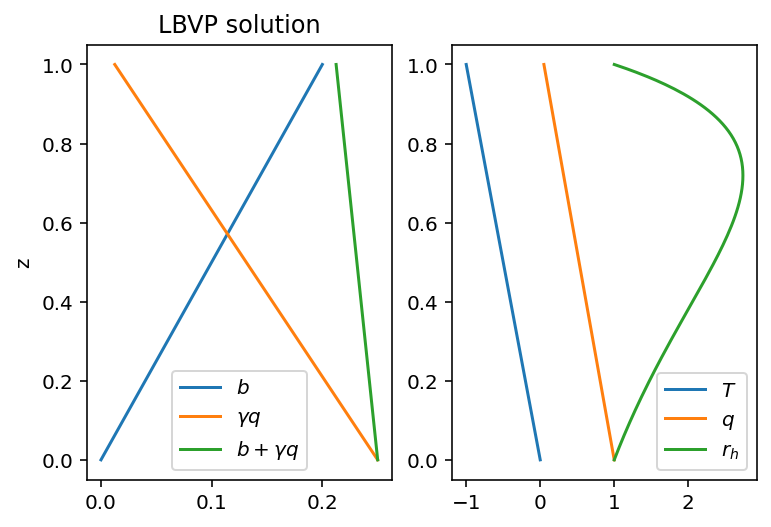

In [7]:
if IC == 'LBVP':
    dt = lambda A: 0*A
    # Stable linear solution as an intial guess
    problem = de.LBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
    problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = 0')
    problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = 0')
    problem.add_equation('b(z=0) = 0')
    problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
    problem.add_equation('q(z=0) = q_surface')
    problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')
    solver = problem.build_solver()
    solver.solve()
else:
    b['g'] = (β + ΔT)*z
    q['g'] = (1-z+np.exp(α*ΔT))
    
print('b: {:.2g} -- {:.2g}'.format(b(z=0).evaluate()['g'][0,0,0], b(z=Lz).evaluate()['g'][0,0,0]))
print('q: {:.2g} -- {:.2g}'.format(q(z=0).evaluate()['g'][0,0,0], q(z=Lz).evaluate()['g'][0,0,0]))

if verbose:
    plot_solution(title='LBVP solution')

In [8]:
dt = lambda A: 0*A

# Stable nonlinear solution
problem = de.NLBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = γ*H(q-qs)*(q-qs)/tau')
problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = - H(q-qs)*(q-qs)/tau')
problem.add_equation('b(z=0) = 0')
problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
problem.add_equation('q(z=0) = q_surface*qs(z=0)')
problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')

In [9]:
for system in ['subsystems']:
     logging.getLogger(system).setLevel(logging.WARNING)

# Relax on k
for k in [1e1, 1e3, 1e5]:
    solver = problem.build_solver(ncc_cutoff=1e-6)
    pert_norm = np.inf
    tol = 1e-2
    while pert_norm > tol:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info("k = {:.0g}, L2 err = {:.1g}".format(k, pert_norm))

# Relax on tau
for tau in [1e-2, 1e-4]:
    solver = problem.build_solver(ncc_cutoff=1e-6)
    pert_norm = np.inf
    tol = 1e-2
    while pert_norm > tol:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info("tau = {:.2g}, L2 err = {:.1g}".format(tau, pert_norm))
    

2022-10-06 15:25:05,181 __main__ 0/1 INFO :: k = 1e+01, L2 err = 0.3
2022-10-06 15:25:05,632 __main__ 0/1 INFO :: k = 1e+01, L2 err = 0.007
2022-10-06 15:25:05,972 __main__ 0/1 INFO :: k = 1e+03, L2 err = 0.001
2022-10-06 15:25:06,297 __main__ 0/1 INFO :: k = 1e+05, L2 err = 3e-06
2022-10-06 15:25:06,629 __main__ 0/1 INFO :: tau = 0.01, L2 err = 8e-11
2022-10-06 15:25:06,956 __main__ 0/1 INFO :: tau = 0.0001, L2 err = 8e-16


array([<AxesSubplot:title={'center':'NLBVP solution'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

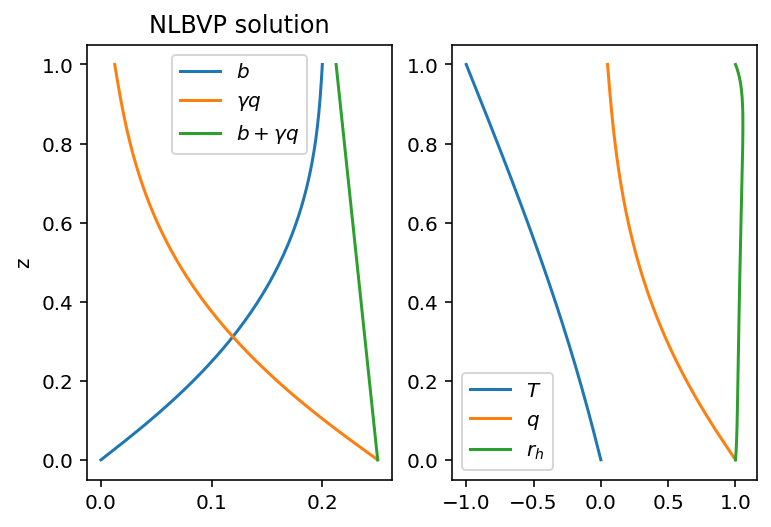

In [10]:
value = rh.evaluate()
value.change_scales(1)
mask = (value['g'] >= 1)
ax = plot_solution(title='NLBVP solution', mask=mask, linestyle='solid')
mask = (value['g'] < 1)
plot_solution(title='NLBVP solution', mask=mask, linestyle='dashed', ax=ax)

In [11]:
b_NLBVP = b.copy()
q_NLBVP = q.copy()

In [12]:
def compute_critical_R(kx, γ, β, tau, nz_evp=64, Lz=1):
    nx = 2
    Lx = 2 * np.pi / kx
    z_scale = nz_evp/nz
    
    coords = de.CartesianCoordinates('x', 'z')
    dist = de.Distributor(coords, dtype=np.complex128)
    xb = de.ComplexFourier(coords['x'], size=nx, bounds=(0, Lx))
    zb = de.ChebyshevT(coords['z'], size=nz_evp, bounds=(0, Lz))
    z = zb.local_grid(1)
    bases = (xb, zb)
    bases_perp = xb

    ex, ez = coords.unit_vector_fields(dist)

    p = dist.Field(name='p', bases=bases)
    u = dist.VectorField(coords, name='u', bases=bases)
    b = dist.Field(name='b', bases=bases)
    q = dist.Field(name='q', bases=bases)

    τu1 = dist.VectorField(coords, name='τu1', bases=bases_perp)
    τu2 = dist.VectorField(coords, name='τu2', bases=bases_perp)
    τp = dist.Field(name='τp')

    τb1 = dist.Field(name='τb1', bases=bases_perp)
    τb2 = dist.Field(name='τb2', bases=bases_perp)
    τq1 = dist.Field(name='τq1', bases=bases_perp)
    τq2 = dist.Field(name='τq2', bases=bases_perp)

    zb1 = zb.clone_with(a=zb.a+1, b=zb.b+1)
    zb2 = zb.clone_with(a=zb.a+2, b=zb.b+2)
    lift1 = lambda A, n: de.Lift(A, zb1, n)
    lift = lambda A, n: de.Lift(A, zb2, n)

    # assume direct onset
    dt = lambda A: 0*A

    R_c = dist.Field(name='(1/sqrt(Ra_c))')
    P = R_c*(Prandtl)**(-1/2)         #  diffusion on buoyancy
    S = R_c*(Prandtlm)**(-1/2) 
    PdR = R_c*(Prandtl)**(1/2)        #  diffusion on momentum
    PtR = 1


    # use the NLBVP to set the fields for the EVP
    b0 = dist.Field(name='b0', bases=zb)
    q0 = dist.Field(name='q0', bases=zb)
    qs0 = dist.Field(name='qs0', bases=zb)
    b_NLBVP.change_scales(z_scale)
    q_NLBVP.change_scales(z_scale)
    b0['g'] = b_NLBVP['g']
    q0['g'] = q_NLBVP['g']

    k = 1e2 #3 #1e5 # cutoff for tanh
    H = lambda A: 0.5*(1+np.tanh(k*A))

    z_grid = dist.Field(name='z_grid', bases=zb)
    z_grid['g'] = z

    temp = b0 - β*z_grid
    temp.name = 'T'
    qs = np.exp(α*temp)

    # rh = q*np.exp(-α*temp)


    problem = de.EVP([p, u, b, q, τp, τu1, τu2, τb1, τb2, τq1, τq2], eigenvalue=R_c, namespace=locals())
    problem.add_equation('div(u) + τp + dot(lift(τu2,-1),ez) = 0')
    problem.add_equation('dt(u) - PdR*lap(u) + grad(p) - PtR*b*ez + lift(τu1, -1) + PdR*lift(τu2, -2) = 0')
    problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) + dot(u, grad(b0)) - γ*H(q0-qs)*(q)/tau  = 0')
    problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) + dot(u, grad(q0)) +   H(q0-qs)*(q)/tau  = 0')
    #problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) + dot(u, grad(b0)) - γ*H(q0-qs)*(q-qs)/tau - γ*H(q-qs)*(q0-qs)/tau = 0')
    #problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) + dot(u, grad(q0)) +   H(q0-qs)*(q-qs)/tau + H(q-qs)*(q0-qs)/tau = 0')
    problem.add_equation('b(z=0) = 0')
    problem.add_equation('b(z=Lz) = 0') # technically β*Lz
    problem.add_equation('q(z=0) = 0')
    problem.add_equation('q(z=Lz) = 0')
    problem.add_equation('u(z=0) = 0')
    problem.add_equation('u(z=Lz) = 0')
    problem.add_equation('integ(p) = 0')
    
    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0])
    sort_indices = np.argsort(np.abs(solver.eigenvalues.real))
    eigenvalues = solver.eigenvalues.real[sort_indices]
    eigenvalues = eigenvalues[eigenvalues > 0]
    eigenvalues = eigenvalues[np.isfinite(eigenvalues)]
    return eigenvalues[0]

In [13]:
R_c = []
nz_evp = 128
kxs = np.logspace(-1, 1, num=20)
for kx in kxs:
    R_c_i = compute_critical_R(kx, γ, β, tau, nz_evp=nz_evp)
    R_c.append(R_c_i)
    logger.info('kx = {:.2g}, R_c = {:.2g}'.format(kx, R_c_i))
R_c = np.array(R_c)

2022-10-06 15:25:08,841 __main__ 0/1 INFO :: kx = 0.1, R_c = 3.2e-21
2022-10-06 15:25:10,526 __main__ 0/1 INFO :: kx = 0.13, R_c = 3.2e-21
2022-10-06 15:25:12,191 __main__ 0/1 INFO :: kx = 0.16, R_c = 3.2e-21
2022-10-06 15:25:13,863 __main__ 0/1 INFO :: kx = 0.21, R_c = 3.2e-21
2022-10-06 15:25:15,548 __main__ 0/1 INFO :: kx = 0.26, R_c = 3.2e-21
2022-10-06 15:25:17,298 __main__ 0/1 INFO :: kx = 0.34, R_c = 3.2e-21
2022-10-06 15:25:19,045 __main__ 0/1 INFO :: kx = 0.43, R_c = 3.2e-21
2022-10-06 15:25:20,738 __main__ 0/1 INFO :: kx = 0.55, R_c = 3.2e-21
2022-10-06 15:25:22,475 __main__ 0/1 INFO :: kx = 0.7, R_c = 3.2e-21
2022-10-06 15:25:24,153 __main__ 0/1 INFO :: kx = 0.89, R_c = 3.2e-21
2022-10-06 15:25:25,846 __main__ 0/1 INFO :: kx = 1.1, R_c = 3.2e-21
2022-10-06 15:25:27,594 __main__ 0/1 INFO :: kx = 1.4, R_c = 3.2e-21
2022-10-06 15:25:29,311 __main__ 0/1 INFO :: kx = 1.8, R_c = 3.2e-21
2022-10-06 15:25:31,043 __main__ 0/1 INFO :: kx = 2.3, R_c = 3.2e-21
2022-10-06 15:25:32,789 __

In [14]:
print(R_c)

[3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21
 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21
 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21
 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21 3.2275399e-21]


In [15]:
def compute_growth_rate(kx, Rayleigh, γ, β, tau, nz_evp=64, Lz=1, NEV=10, target=0):
    nx = 2
    Lx = 2 * np.pi / kx
    z_scale = nz_evp/nz
    
    coords = de.CartesianCoordinates('x', 'z')
    dist = de.Distributor(coords, dtype=np.complex128)
    xb = de.ComplexFourier(coords['x'], size=nx, bounds=(0, Lx))
    zb = de.ChebyshevT(coords['z'], size=nz_evp, bounds=(0, Lz))
    z = zb.local_grid(1)
    bases = (xb, zb)
    bases_perp = xb

    ex, ez = coords.unit_vector_fields(dist)

    p = dist.Field(name='p', bases=bases)
    u = dist.VectorField(coords, name='u', bases=bases)
    b = dist.Field(name='b', bases=bases)
    q = dist.Field(name='q', bases=bases)

    τu1 = dist.VectorField(coords, name='τu1', bases=bases_perp)
    τu2 = dist.VectorField(coords, name='τu2', bases=bases_perp)
    τp = dist.Field(name='τp')

    τb1 = dist.Field(name='τb1', bases=bases_perp)
    τb2 = dist.Field(name='τb2', bases=bases_perp)
    τq1 = dist.Field(name='τq1', bases=bases_perp)
    τq2 = dist.Field(name='τq2', bases=bases_perp)

    zb1 = zb.clone_with(a=zb.a+1, b=zb.b+1)
    zb2 = zb.clone_with(a=zb.a+2, b=zb.b+2)
    lift1 = lambda A, n: de.Lift(A, zb1, n)
    lift = lambda A, n: de.Lift(A, zb2, n)

    # assume direct onset
    dt = lambda A: -1j*ω*A

    ω = dist.Field(name='ω')
    P = (Rayleigh * Prandtl)**(-1/2)         #  diffusion on buoyancy
    S = (Rayleigh * Prandtlm)**(-1/2)        #  diffusion on moisture
    PdR = (Prandtl / Rayleigh)**(1/2)        #  diffusion on momentum    
    PtR = 1

    # use the NLBVP to set the fields for the EVP
    b0 = dist.Field(name='b0', bases=zb)
    q0 = dist.Field(name='q0', bases=zb)
    qs0 = dist.Field(name='qs0', bases=zb)
    b_NLBVP.change_scales(z_scale)
    q_NLBVP.change_scales(z_scale)
    b0['g'] = b_NLBVP['g']
    q0['g'] = q_NLBVP['g']

    k = 1e2 #3 #1e5 # cutoff for tanh
    H = lambda A: 0.5*(1+np.tanh(k*A))

    z_grid = dist.Field(name='z_grid', bases=zb)
    z_grid['g'] = z

    temp = b0 - β*z_grid
    temp.name = 'T'
    qs = np.exp(α*temp)

    # rh = q*np.exp(-α*temp)


    problem = de.EVP([p, u, b, q, τp, τu1, τu2, τb1, τb2, τq1, τq2], eigenvalue=ω, namespace=locals())
    problem.add_equation('div(u) + τp + dot(lift(τu2,-1),ez) = 0')
    problem.add_equation('dt(u) - PdR*lap(u) + grad(p) - PtR*b*ez + lift(τu1, -1) + PdR*lift(τu2, -2) = 0')
    problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) + dot(u, grad(b0)) - γ*H(q0-qs)*(q)/tau  = 0')
    problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) + dot(u, grad(q0)) +   H(q0-qs)*(q)/tau  = 0')
    #problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) + dot(u, grad(b0)) - γ*H(q0-qs)*(q-qs)/tau - γ*H(q-qs)*(q0-qs)/tau = 0')
    #problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) + dot(u, grad(q0)) +   H(q0-qs)*(q-qs)/tau + H(q-qs)*(q0-qs)/tau = 0')
    problem.add_equation('b(z=0) = 0')
    problem.add_equation('b(z=Lz) = 0') # technically β*Lz
    problem.add_equation('q(z=0) = 0')
    problem.add_equation('q(z=Lz) = 0')
    problem.add_equation('u(z=0) = 0')
    problem.add_equation('u(z=Lz) = 0')
    problem.add_equation('integ(p) = 0')

    solver = problem.build_solver()
    solver.solve_sparse(solver.subproblems[1], NEV, target=target)
    return np.max(solver.eigenvalues.imag)

In [16]:
growth_rates = {}

Ras = np.logspace(4,5,num=10)
for Ra in Ras:
    σ = []
    nz_evp = 128
    kxs = np.logspace(-1, 2, num=30)
    for kx in kxs:
        σ_i = compute_growth_rate(kx, Ra, γ, β, tau, nz_evp=nz_evp)
        σ.append(σ_i)
        logger.info('Ra = {:.1g}, kx = {:.2g}, σ = {:.2g}'.format(Ra, kx, σ_i))
    σ = np.array(σ)
    growth_rates[Ra] = σ

2022-10-06 15:25:42,374 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.1, σ = -0.099
2022-10-06 15:25:43,480 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.13, σ = -0.099
2022-10-06 15:25:44,487 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.16, σ = -0.099
2022-10-06 15:25:45,493 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.2, σ = -0.099
2022-10-06 15:25:46,501 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.26, σ = -0.099
2022-10-06 15:25:47,500 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.33, σ = -0.099
2022-10-06 15:25:48,506 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.42, σ = -0.099
2022-10-06 15:25:49,511 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.53, σ = -0.099
2022-10-06 15:25:50,525 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.67, σ = -0.099
2022-10-06 15:25:51,524 __main__ 0/1 INFO :: Ra = 1e+04, kx = 0.85, σ = -0.099
2022-10-06 15:25:52,563 __main__ 0/1 INFO :: Ra = 1e+04, kx = 1.1, σ = -0.1
2022-10-06 15:25:53,556 __main__ 0/1 INFO :: Ra = 1e+04, kx = 1.4, σ = -0.1
2022-10-06 15:25:54,555 __main__ 0/1 INFO :: Ra = 1e+04, kx 

2022-10-06 15:27:28,912 __main__ 0/1 INFO :: Ra = 2e+04, kx = 5.7, σ = -0.16
2022-10-06 15:27:29,838 __main__ 0/1 INFO :: Ra = 2e+04, kx = 7.3, σ = -0.28
2022-10-06 15:27:30,757 __main__ 0/1 INFO :: Ra = 2e+04, kx = 9.2, σ = -0.49
2022-10-06 15:27:31,682 __main__ 0/1 INFO :: Ra = 2e+04, kx = 12, σ = -0.83
2022-10-06 15:27:32,753 __main__ 0/1 INFO :: Ra = 2e+04, kx = 15, σ = -1.4
2022-10-06 15:27:33,687 __main__ 0/1 INFO :: Ra = 2e+04, kx = 19, σ = -2.3
2022-10-06 15:27:34,615 __main__ 0/1 INFO :: Ra = 2e+04, kx = 24, σ = -3.8
2022-10-06 15:27:35,637 __main__ 0/1 INFO :: Ra = 2e+04, kx = 30, σ = -6.2
2022-10-06 15:27:36,648 __main__ 0/1 INFO :: Ra = 2e+04, kx = 39, σ = -10
2022-10-06 15:27:37,647 __main__ 0/1 INFO :: Ra = 2e+04, kx = 49, σ = -16
2022-10-06 15:27:38,749 __main__ 0/1 INFO :: Ra = 2e+04, kx = 62, σ = -26
2022-10-06 15:27:39,785 __main__ 0/1 INFO :: Ra = 2e+04, kx = 79, σ = -42
2022-10-06 15:27:40,840 __main__ 0/1 INFO :: Ra = 2e+04, kx = 1e+02, σ = -68
2022-10-06 15:27:41,

2022-10-06 15:29:12,835 __main__ 0/1 INFO :: Ra = 6e+04, kx = 0.26, σ = -0.039
2022-10-06 15:29:13,755 __main__ 0/1 INFO :: Ra = 6e+04, kx = 0.33, σ = -0.038
2022-10-06 15:29:14,711 __main__ 0/1 INFO :: Ra = 6e+04, kx = 0.42, σ = -0.037
2022-10-06 15:29:15,643 __main__ 0/1 INFO :: Ra = 6e+04, kx = 0.53, σ = -0.035
2022-10-06 15:29:16,562 __main__ 0/1 INFO :: Ra = 6e+04, kx = 0.67, σ = -0.032
2022-10-06 15:29:17,532 __main__ 0/1 INFO :: Ra = 6e+04, kx = 0.85, σ = -0.028
2022-10-06 15:29:18,517 __main__ 0/1 INFO :: Ra = 6e+04, kx = 1.1, σ = -0.022
2022-10-06 15:29:19,451 __main__ 0/1 INFO :: Ra = 6e+04, kx = 1.4, σ = -0.014
2022-10-06 15:29:20,360 __main__ 0/1 INFO :: Ra = 6e+04, kx = 1.7, σ = -0.0046
2022-10-06 15:29:21,275 __main__ 0/1 INFO :: Ra = 6e+04, kx = 2.2, σ = 0.0057
2022-10-06 15:29:22,221 __main__ 0/1 INFO :: Ra = 6e+04, kx = 2.8, σ = 0.014
2022-10-06 15:29:23,254 __main__ 0/1 INFO :: Ra = 6e+04, kx = 3.6, σ = 0.016
2022-10-06 15:29:24,282 __main__ 0/1 INFO :: Ra = 6e+04, kx

Text(0, 0.5, '$k_x$')

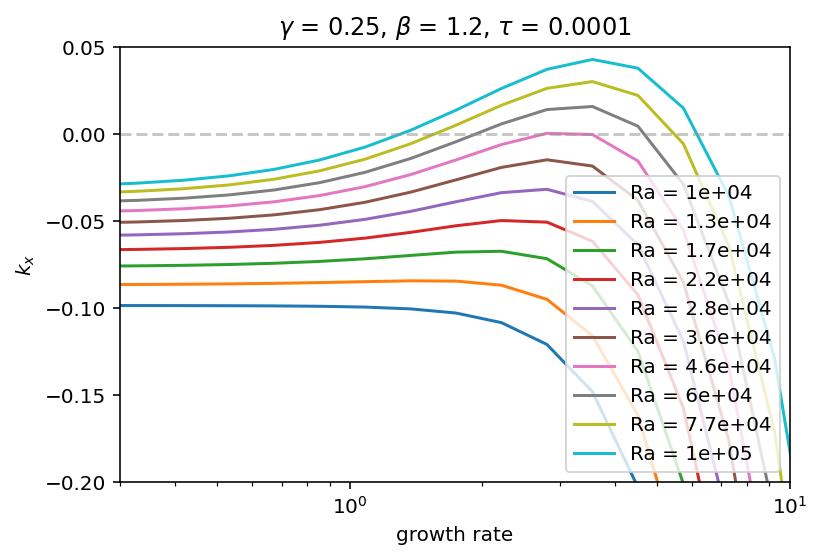

In [17]:
fig, ax = plt.subplots()
peak_σ = -np.inf
for Ra in growth_rates:
    σ = growth_rates[Ra]
    peak_σ = max(peak_σ, np.max(σ))
    ax.plot(kxs, σ, label='Ra = {:.2g}'.format(Ra))
ax.set_xscale('log')
ax.set_ylim(-0.2, 0.05)
ax.legend()
ax.axhline(y=0, linestyle='dashed', color='xkcd:grey', alpha=0.5)
ax.set_xlim(3e-1,1e1)
ax.set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\tau$ = {:}'.format(γ,β, tau))
ax.set_xlabel('growth rate')
ax.set_ylabel('$k_x$')